Try to combine the binary classification NN and categorical classification NN in a mixed model

In [9]:
import numpy as np
# Load X and y
X = np.load('X.npy')
y = np.load('y.npy')

n_cl = 5

# Load the two NN models
from tensorflow.keras.models import load_model
NN_binary = load_model('NN_rhythm_binary.keras')
NN_categorical = load_model('NN_rhythm_categorical_1_4.keras')

In [10]:
def mixed_model(X):
    # Predict health status: shape (n_patients, 2)
    healthy_pred = NN_binary.predict(X)
    # Healthy if [0,1], i.e., argmax==1
    is_healthy = np.argmax(healthy_pred, axis=1) == 1

    # Prepare output: shape (n_patients, 5)
    out = np.zeros((X.shape[0], n_cl), dtype=np.float32)

    # For healthy patients, set class 4 (zero-based)
    out[is_healthy, n_cl-1] = 1

    # For unhealthy patients, get categorical prediction (shape: [n_unhealthy, 4])
    if np.any(~is_healthy):
        cat_pred = NN_categorical.predict(X[~is_healthy])  # shape: (n_unhealthy, 4)
        out[~is_healthy, :n_cl-1] = cat_pred  # Fill first 4 classes

    return out

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
F1 score: 0.9664863586292721


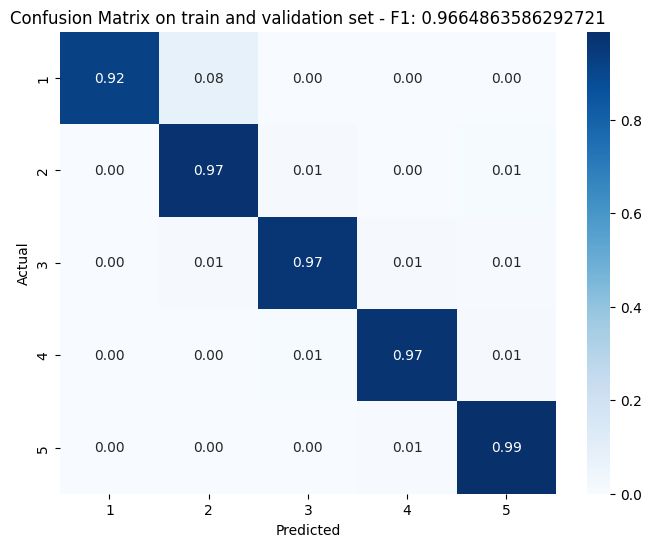

In [12]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Example true labels and predicted labels
y_true = np.argmax((y), axis=-1)
y_pred = np.argmax(mixed_model(X), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set - F1: {f1}')
plt.show()

In [13]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1))


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F1 score: 0.9103741136094078


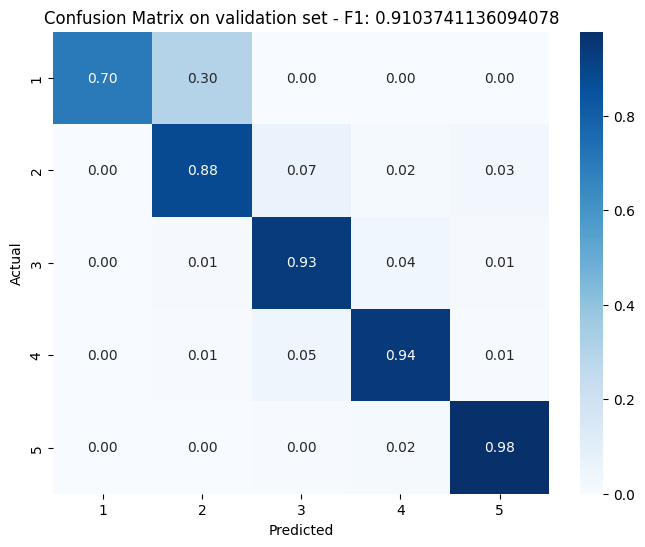

In [14]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(y_val, axis=-1)
y_pred = np.argmax(mixed_model(X_val), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set - F1: {f1}')
plt.show()